# Introduction to JAX

Written by Ben Moseley, June 2024


## What is JAX?

<img src="what-is-jax.png" width=80%>

In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=2'
import jax
import matplotlib.pyplot as plt
import numpy as np

# Arrays with JAX NumPy

In [2]:
import jax.numpy as jnp

x = jnp.array([[0., 2., 4.]])
print(x, x.shape)
print(x @ x.T)
print(x * x.T)

[[0. 2. 4.]] (1, 3)
[[20.]]
[[ 0.  0.  0.]
 [ 0.  4.  8.]
 [ 0.  8. 16.]]


# Autodifferentiation with JAX

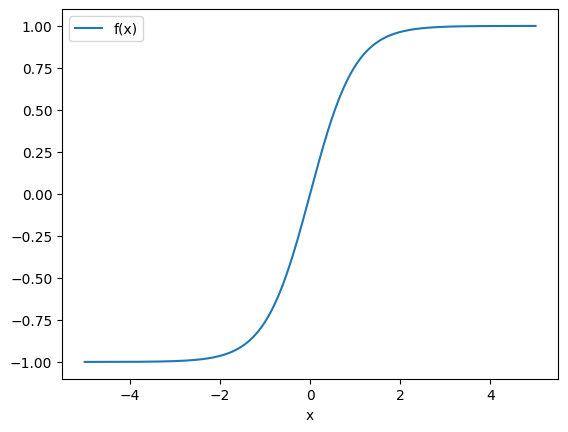

In [3]:
def fn(x):
    return jnp.tanh(x)

x = jnp.linspace(-5,5,500)

plt.plot(x, fn(x), label="f(x)")
plt.legend()
plt.xlabel("x")
plt.show()

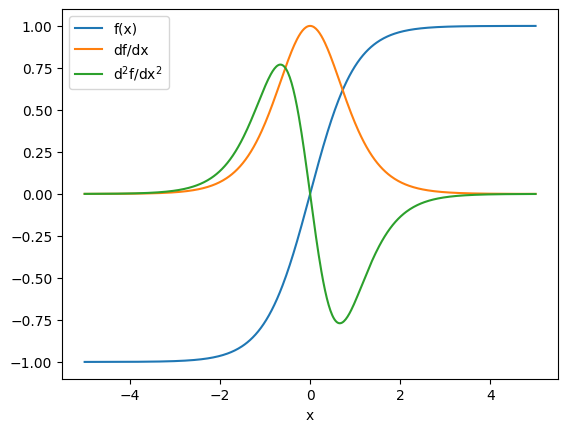

In [4]:
# gradient
dfdx_fn = jax.grad(fn)# assumes f is a scalar-output function
d2fdx2_fn = jax.grad(dfdx_fn)

plt.plot(x, fn(x), label="f(x)")
plt.plot(x, [dfdx_fn(x_) for x_ in x], label="df/dx")
plt.plot(x, [d2fdx2_fn(x_) for x_ in x], label="d$^2$f/dx$^2$")
plt.legend()
plt.xlabel("x")
plt.show()

In [5]:
print(jax.make_jaxpr(fn)(x))# JAX transforms programs using a simple intermediate language call jaxpr

{ lambda ; a:f32[500]. let b:f32[500] = tanh a in (b,) }


In [6]:
# Jacobian
jacobian_fn = jax.jacfwd(fn)
j = jacobian_fn(x)
print(j)
print(j.shape)

[[0.00018167 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00018894 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00019669 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00019669 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00018894 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00018167]]
(500, 500)


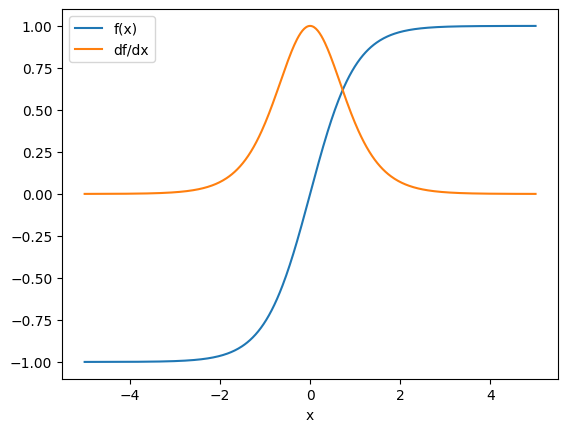

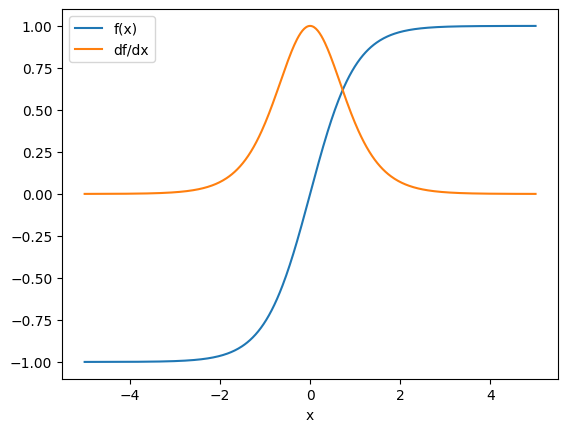

In [7]:
# vector-Jacobian product
f, vjp_fn = jax.vjp(fn, x)
dfdx, = vjp_fn(jnp.ones_like(x))

plt.plot(x, f, label="f(x)")
plt.plot(x, dfdx, label="df/dx")
plt.legend()
plt.xlabel("x")
plt.show()

# Jacobian-vector product
f, dfdx = jax.jvp(fn, (x,), (jnp.ones_like(x),))

plt.plot(x, f, label="f(x)")
plt.plot(x, dfdx, label="df/dx")
plt.legend()
plt.xlabel("x")
plt.show()

# Vectorisation with JAX

In [8]:
def forward_fn(w, b, x):
    x = w @ x + b
    x = jnp.tanh(x)
    return x

key = jax.random.key(seed=0)
key1, key2, key3 = jax.random.split(key, 3)
x = jax.random.normal(key1, (3,))
w = jax.random.normal(key2, (10,3))
b = jax.random.normal(key3, (10,))
y = forward_fn(w, b, x)
print(x.shape)
print(y.shape)

(3,)
(10,)


In [9]:
forward_batch_fn = jax.vmap(forward_fn, in_axes=(None, None, 0))# computes batch using vectorisation

x_batch = jax.random.normal(key, (1000,3))
y_batch = forward_batch_fn(w, b, x_batch)
print(x_batch.shape)
print(y_batch.shape)

(1000, 3)
(1000, 10)


# Just-in-time compilation with JAX

In [10]:
def fn(x):
    return x + x*x + x*x*x

jit_fn = jax.jit(fn)

x = jax.random.normal(key, (1000,1000))
%timeit fn(x).block_until_ready()
%timeit jit_fn(x).block_until_ready()

881 µs ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
111 µs ± 228 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Putting it all together: polynominal regression with JAX

The goal of this task is to gain a basic familiarity with JAX's function transforms (`vmap`, `jit`, `grad`).

We will carry out polynominal regression, using the following data:

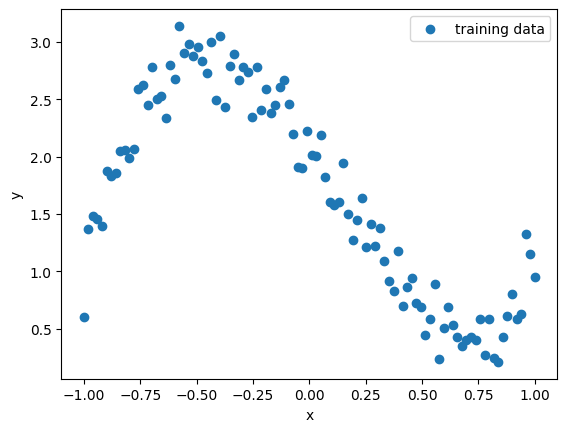

In [11]:
key = jax.random.key(0)
x_batch = jnp.linspace(-1, 1, 100).reshape((100,1))
y_label_batch = 3*x_batch**3 - x_batch**2 - 3*x_batch + 2 + 0.2*jax.random.normal(key, (100,1))

plt.scatter(x_batch, y_label_batch, label="training data")
plt.legend()
plt.xlabel("x"); plt.ylabel("y")
plt.show()

> Task: define a `forward(theta, x)` function, which predicts `y` given a single `x` value and some learnable parameters, `theta`.

> Task: use `jax.vmap` to transform `forward` to a function which predicts a batch of `y` values given a batch of `x` values. Test that it works using `x_batch` above.

Hint: you can assume that the function is a third order polynominal, and learn its coefficients.

In [12]:
def forward(theta, x):
    "Returns model prediction, for a single example input"
    y = theta[0]*x**3 + theta[1]*x**2 + theta[2]*x + theta[3]
    return y

forward_batch = jax.vmap(forward, in_axes=(None, 0))# batched version of forward

theta = jnp.zeros(4, dtype=float)
print(forward_batch(theta, x_batch).shape)

(100, 1)


> Task: next, define a `loss(theta, x_batch, y_label_batch)` function which computes the mean-squared error of the model.

> Task: use `jax.grad` to transform `loss` into a function which computes the gradient of `loss` with respect to the model parameters, `theta`. Test that it outputs an array the same shape as `theta`.

In [13]:
def loss(theta, x_batch, y_label_batch):
    "Computes mean squared error between model prediction and training data"
    y_batch = forward_batch(theta, x_batch)
    loss = jnp.mean((y_batch-y_label_batch)**2)
    return loss

grad = jax.value_and_grad(loss, argnums=0)# gradient of loss wrt model parameters

print(grad(theta, x_batch, y_label_batch)[1])

[ 0.33085966 -0.937689    0.7706356  -3.3527174 ]


> Task: define an `step(lrate, theta, x_batch, y_label_batch)` function which carries out a single gradient descent step on `theta`, using the `grad` function you created above. It should return the updated `theta`.

> Task: use `jax.jit` to compile `step`.

In [14]:
def step(lrate, theta, x_batch, y_label_batch):
    "Performs one gradient descent step on model parameters, given training data"
    lossval, dldt = grad(theta, x_batch, y_label_batch)
    theta = jax.tree_util.tree_map(lambda t,dt: t-lrate*dt, theta, dldt)
    return theta, lossval

jit_step = jax.jit(step)# makes step go brr

> Task: finally, write a python `for` loop to train the model over 1000 gradient descent steps, with a learning rate of 0.1. You are free to choose how to initialise `theta`. Plot the results of the model.

> Task: compare the speed of training with/without `jit` compilation. How much faster is the compiled code?

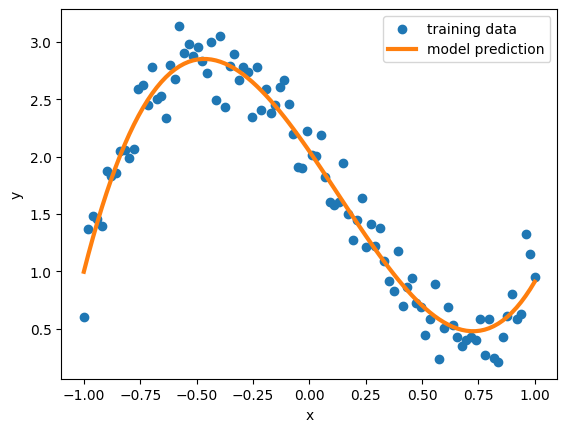

[ 2.8000598 -1.0945083 -2.84339    2.0485647]
14.4 µs ± 68.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
7.49 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
# initialise theta
theta = jnp.zeros(4, dtype=float)

# run gradient descent
for i in range(1000):
    theta, lossval = jit_step(0.1, theta, x_batch, y_label_batch)

plt.scatter(x_batch, y_label_batch, label="training data")
plt.plot(x_batch, forward_batch(theta, x_batch), color="tab:orange", lw=3, label="model prediction")
plt.legend()
plt.xlabel("x"); plt.ylabel("y")
plt.show()
print(theta)

%timeit jit_step(0.1, theta, x_batch, y_label_batch)[1].block_until_ready()
%timeit step(0.1, theta, x_batch, y_label_batch)[1].block_until_ready()

# 🔪 JAX: the sharp bits

JAX introduces a number of **restrictions** which are necessary for JAX transformations to work (`vmap`, `grad`, `jit`, etc).

Below are most of the major ones. See [here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) for a full list.

## 🔪 Pure functions

JAX transforms are designed to work on pure functions.

That is, all the input data is passed through the function parameters, and all the results are output through the function results. 

Otherwise unexpect results might occur! Note: this makes transforming Python classes tricky (but not [impossible](https://jax.readthedocs.io/en/latest/stateful-computations.html))

In [16]:
x = 10
def f(a):
    return x+a

print(jax.make_jaxpr(f)(1))# when we jit this function, the current value of x is hard-coded into the compiled code!
jit_f = jax.jit(f)
print(jit_f(1))
x = 20
print(jit_f(1))# (!) not what you expect (!)

{ lambda ; a:i32[]. let b:i32[] = add 10 a in (b,) }
11
11


## 🔪🔪 Static shapes
JAX transforms require all output shapes to be known in **advance**, given the input shapes.

This is probably the biggest restriction. We can't transform functions which output dynamic shapes:

In [17]:
def f(i):
    return jnp.ones(shape=(i,))

print(f(jnp.array(10)))
#print(jax.jit(f)(jnp.array(10)))# raises a TypeError

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


🔪 This means **dynamic programming** and **sparse (matrix) computation** can often be challenging in JAX (although tricks like masking and compressed representations can be used).

## 🔪 Out-of-place array updates

JAX only allows **out-of-place** array updates. 

This is because allowing mutation of variables in-place makes program analysis and transformation difficult.

In [18]:
a = np.array([1,2,3])
a[0] = -1# you are used to doing this

a = jnp.array([1,2,3])
#a[0] = 1# will raise a TypeError
b = a.at[0].set(-1)# this is the JAX equivalent
print(b)

[-1  2  3]


## 🔪 Random numbers

JAX handles random number generation explicitly ([for good reason](https://jax.readthedocs.io/en/latest/random-numbers.html)). 

This means the user must explicitly carry around the state of the random number generator:

In [19]:
key = jax.random.key(0)
print(jax.random.normal(key, (1,)))
print(jax.random.normal(key, (1,)))# generates same number
key, subkey = jax.random.split(key, num=2)# we need to explicitly split the RNG to generate new numbers
print(jax.random.normal(subkey, (1,)))

[-0.20584226]
[-0.20584226]
[-1.2515389]


# Extra: multi-device parallelisation with JAX

In [20]:
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

print(jax.devices())

x = jax.random.normal(key, (8192, 8192))

sharding = PositionalSharding(jax.devices()).reshape(2,1)
x = jax.device_put(x, sharding)
jax.debug.visualize_array_sharding(x)# shards array across first dimension

y = x**2
jax.debug.visualize_array_sharding(y)# "computation follows sharding" paradigm

y = jnp.mean(x**2, axis=0, keepdims=True)# compiler also inserts communication as necessary!
jax.debug.visualize_array_sharding(y)# result is replicated across devices

[CpuDevice(id=0), CpuDevice(id=1)]


                         
                         
          CPU 0          
                         
                         
                         
                         
                         
          CPU 1          
                         
                         
                         

                         
                         
          CPU 0          
                         
                         
                         
                         
                         
          CPU 1          
                         
                         
                         

                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                    CPU 0,1                                     
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                